In [1]:
import nltk
import re
import numpy as np
import networkx as nx
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from heapq import nlargest

# --- NLTK Resource Management (Run once on module load) ---
def _ensure_nltk_resources():
    """Checks and downloads necessary NLTK resources."""
    resources = ['stopwords', 'punkt', 'averaged_perceptron_tagger']
    for resource in resources:
        try:
            # Check for specific resource, e.g., stopwords.words('english')
            if resource == 'stopwords':
                stopwords.words('english')
            elif resource == 'punkt':
                sent_tokenize("Test.")
            elif resource == 'averaged_perceptron_tagger':
                nltk.pos_tag(word_tokenize("Test"))
        except LookupError:
            print(f"Downloading NLTK resource: {resource}...")
            nltk.download(resource)

_ensure_nltk_resources() 

class TextRankSummarizer:
    """
    A Hybrid Extractive-Compressive Summarizer based on TextRank
    and deterministic Part-of-Speech (POS) based sentence pruning.
    
    The summary length is controlled by the percentage of the original total word count.
    """

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.vectorizer = TfidfVectorizer()

    def _clean_and_process_sentences(self, text):
        """Tokenizes text and cleans sentences for vectorization."""
        # Use NLTK's robust sentence tokenizer
        original_sentences = sent_tokenize(text)
        
        cleaned_sentences = []
        for s in original_sentences:
            # Remove non-alphabetic characters and lowercase
            s_clean = re.sub(r'[^a-zA-Z\s]', '', s.lower())
            words = s_clean.split()
            # Remove stop words
            s_processed = ' '.join([word for word in words if word not in self.stop_words])
            cleaned_sentences.append(s_processed)

        return original_sentences, cleaned_sentences

    def _compress_sentence(self, sentence):
        """
        Compresses a single sentence by removing non-essential POS tags.
        
        If an error occurs during POS tagging (e.g., missing resource), the
        original sentence words are preserved to prevent returning an empty string.
        """
        words = word_tokenize(sentence)
        
        try:
            # Part-of-Speech Tagging
            tagged_words = nltk.pos_tag(words)
        except Exception as e:
            # If POS tagging fails, use original words without compression
            print(f"Warning: POS tagging failed for sentence. Returning original words. Error: {e}")
            compressed_words = words
            
            # If tagging failed, skip to the joining section
            compressed_text = ' '.join(compressed_words)
            compressed_text = re.sub(r'\s([,\.\?!:])', r'\1', compressed_text)
            return compressed_text.capitalize()
            
        # Define the set of essential tags (core SVO)
        essential_tags = {'NN', 'NNS', 'NNP', 'NNPS',  # Nouns
                          'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', # Verbs
                          'PRP', 'DT', 'CD', 'IN', 'CC'} # Pronouns, Determiners, Numbers, Prepositions, Conjunctions

        compressed_words = []
        for word, tag in tagged_words:
            # Simple check: keep if the tag is in the essential set
            if tag in essential_tags or tag.startswith('NN') or tag.startswith('VB'):
                 compressed_words.append(word)
        
        # FIX: If compression removed ALL words (but there were input words),
        # return original words to avoid empty string.
        if not compressed_words and words:
             compressed_words = [word for word, tag in tagged_words if word.isalnum()]
             if not compressed_words: # Final safeguard
                 compressed_words = words

        # Simple join. A more advanced method would re-insert proper punctuation.
        compressed_text = ' '.join(compressed_words)
        
        # Simple fix for punctuation spacing
        compressed_text = re.sub(r'\s([,\.\?!:])', r'\1', compressed_text)
        
        return compressed_text.capitalize() # Start with a capital letter

    def _handle_single_sentence_case(self, original_sentences, cleaned_sentences, target_word_count):
        """
        Handle the special case when there's only one sentence.
        Applies compression and returns the result.
        """
        if not original_sentences:
            return "Cannot summarize empty content."
            
        single_sentence = original_sentences[0]
        compressed = self._compress_sentence(single_sentence)
        compressed_words = compressed.split()
        
        # If the compressed version is within target or we have only one sentence,
        # return the compressed version
        if len(compressed_words) <= target_word_count or len(original_sentences) == 1:
            return compressed
        else:
            # If compressed is still too long, truncate to target word count
            return ' '.join(compressed_words[:target_word_count])

    def summarize(self, input_text, summary_percentage=0.7):
        """
        Generates the compressed summary.
        
        The summary length is determined by a percentage of the original word count.

        Args:
            input_text (str): The document to summarize.
            summary_percentage (float): Percentage of original total word count to target.
        """
        original_sentences, cleaned_sentences = self._clean_and_process_sentences(input_text)

        if not original_sentences or all(not s for s in cleaned_sentences):
            return "Cannot summarize empty or non-text content."

        # Calculate total original words for percentage target
        total_original_words = sum(len(word_tokenize(s)) for s in original_sentences)
        target_word_count = int(total_original_words * summary_percentage)
        
        if target_word_count == 0:
            # If the text is short and target is small, ensure at least one word is targeted
            target_word_count = 1

        # --- SPECIAL CASE: Single sentence ---
        if len(original_sentences) == 1:
            return self._handle_single_sentence_case(original_sentences, cleaned_sentences, target_word_count)

        # --- MULTIPLE SENTENCES: Normal TextRank processing ---
        
        try:
            sentence_vectors = self.vectorizer.fit_transform(cleaned_sentences)
        except ValueError:
            return "The document contains no significant words after cleaning."

        # Building the Graph via Cosine Similarity
        similarity_matrix = cosine_similarity(sentence_vectors)
        
        # Create graph and calculate PageRank scores
        graph = nx.from_numpy_array(similarity_matrix)
        scores = nx.pagerank(graph) 

        # Map scores to original indices
        ranked_sentences = {i: scores[i] for i in range(len(original_sentences))}
        
        # Sort all sentences by score in descending order
        sorted_ranks = sorted(ranked_sentences.items(), 
                              key=lambda item: item[1], 
                              reverse=True)
                                             
        # --- WORD-BASED SELECTION, COMPRESSION & RECONSTRUCTION ---
        
        selected_sentences_by_index = {}
        current_word_count = 0
        
        # Iterate through sentences from most important to least important
        for index, score in sorted_ranks:
            original_sentence = original_sentences[index]
            
            # 1. Compress the sentence deterministically
            compressed_sentence = self._compress_sentence(original_sentence)
            compressed_length = len(compressed_sentence.split())
            
            # 2. Check if adding the sentence exceeds the target word count
            if current_word_count + compressed_length <= target_word_count:
                selected_sentences_by_index[index] = compressed_sentence
                current_word_count += compressed_length
            else:
                # If we go over the limit, stop adding sentences
                break
                
        # If no sentences were selected (all were too long), pick the top one
        if not selected_sentences_by_index and sorted_ranks:
            top_index = sorted_ranks[0][0]
            compressed = self._compress_sentence(original_sentences[top_index])
            compressed_words = compressed.split()
            # Return truncated version if needed
            if len(compressed_words) > target_word_count:
                selected_sentences_by_index[top_index] = ' '.join(compressed_words[:target_word_count])
            else:
                selected_sentences_by_index[top_index] = compressed
                
        # 3. Reconstruct the summary in original order
        final_summary_parts = []
        
        # Sort the selected sentences by their original index (key)
        for index in sorted(selected_sentences_by_index.keys()):
            final_summary_parts.append(selected_sentences_by_index[index])
            
        return " ".join(final_summary_parts)


In [2]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("nvidia/HelpSteer", split="train")

In [3]:
df = df = dataset.to_pandas()

In [4]:
df = df[df["prompt"].str.len() > 1000]
df = df[df["complexity"] == 1]
df = df[df["verbosity"] == 4]
df

,prompt,response,helpfulness,correctness,coherence,complexity,verbosity
1012,Reference:\nMaybe you sold it to buy junk. Tho...,"Who can help the heart, which is grand and ful...",1,1,4,1,4
1234,Read this for context:\n<start of reference>\n...,The reference text suggests that Mr. Nikolai T...,2,3,3,1,4
2002,Reference:\nThe owner of the verified Twitter ...,- The actor Will Smith does not have an offici...,3,2,3,1,4
3352,Read this for context:\nRead More\n\nThere wil...,The potential benefits of the predicted popula...,3,4,3,1,4
4973,Refer to the information below to help with th...,[Sad] [Cinderella] [Ran inside]\n[Angry] [Cind...,2,3,3,1,4
6714,according to the following reference text deli...,Local residents gathered at the Toledo Lucas C...,4,3,4,1,4
7594,The reference text below provides context for ...,Rewarding children for certain behaviors and r...,2,2,3,1,4
7769,Refer to the information below to help with th...,"""The rain comes late, draws the afternoon into...",2,2,2,1,4
8338,Reference:\nTwo days after a naked man stood o...,After the Vatican Gendarmerie took the man to ...,3,4,4,1,4
10800,Reference:\nFormer President Donald Trump has ...,Yes\n\nDonald Trump believes that Kim Reynolds...,2,3,2,1,4


In [5]:
import requests
import time
import json
import os
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv("GEMINI_API_KEY")
MODEL_NAME = "gemini-2.5-flash-preview-09-2025"
API_URL = f"https://generativelanguage.googleapis.com/v1beta/models/{MODEL_NAME}:generateContent"
MAX_RETRIES = 5

def generate_content_with_retry(prompt: str, system_prompt: str) -> dict:
    """
    Sends a request to the Gemini API with exponential backoff for reliability.

    Args:
        prompt: The user query to send to the model.
        system_prompt: The instruction to guide the model's behavior.

    Returns:
        The JSON response from the API, or an empty dictionary on failure.
    """
    if not API_KEY:
        print("Error: API_KEY is missing. Please set your API key.")
        return {}

    # Define the core API request payload
    payload = {
        "contents": [{"parts": [{"text": prompt}]}],
        "systemInstruction": {"parts": [{"text": system_prompt}]},
        # Optional: Add tools:[{"google_search": {}}] here if you need grounding/web search
    }

    headers = {'Content-Type': 'application/json'}
    
    for attempt in range(MAX_RETRIES):
        try:
            # Construct the full URL with the API key
            full_url = f"{API_URL}?key={API_KEY}"
            
            # Use a short timeout suitable for "fast prompting"
            response = requests.post(
                full_url, 
                headers=headers, 
                data=json.dumps(payload),
                timeout=30 # 30 seconds timeout
            )
            response.raise_for_status() # Raises an exception for HTTP errors (4xx or 5xx)
            
            # Success! Return the parsed JSON response
            return response.json()

        except requests.exceptions.HTTPError as e:
            # Handle specific HTTP error codes that suggest retrying
            if response.status_code in [429, 500, 503]: # Too Many Requests, Internal Server Error, Service Unavailable
                delay = 2 ** attempt + 1 # Exponential backoff: 2^0+1, 2^1+1, 2^2+1, ...
                time.sleep(delay)
            else:
                # Other HTTP errors (e.g., 400 Bad Request, 401 Unauthorized) are generally not retryable
                return {}
        
        except requests.exceptions.RequestException as e:
            # Handle network issues, connection errors, and timeouts
            delay = 2 ** attempt + 1
            time.sleep(delay)

    return {}


def ask_prompt(user_prompt):
    """Main function to run the fast prompting script."""
    
    # 2. Define the system instruction for 'fast' and concise output
    system_instruction = (
        "You are an extremely fast and concise AI assistant. Your responses must be "
        "direct, short, and immediately answer the user's query without any preamble or fluff. "
    )

    
    # Send the request
    api_response = generate_content_with_retry(user_prompt, system_instruction)
    
    if api_response:
        # Extract the text content
        try:
            text_response = api_response['candidates'][0]['content']['parts'][0]['text']
            return text_response
        except (KeyError, IndexError) as e:
            print(f"Error parsing response structure: {e}")
    else:
        print("Could not retrieve content from the API.")

    

In [6]:
df_test = df[["prompt", "response"]]
df_test = df_test[:3]

# print(len(df_test.iloc[0]["prompt"]))
# print(len(textrank_summarize(df_test.iloc[0]["prompt"])))
#prompt_responses = [ask_prompt(dt) for dt in df_test["prompt"]]

In [7]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
def evaluate(prompt, threshold, metric):
    tr = TextRankSummarizer()
    prompt_summarized = tr.summarize(prompt, summary_percentage=threshold)
    print(len(prompt))
    print(len(prompt_summarized))
    if metric == "cosin":
    # Krok 1: Inicjalizacja Modelu Osadzania
    # all-MiniLM-L6-v2 jest szybki i zapewnia dobrą jakość osadzania zdań.
        model = SentenceTransformer('all-MiniLM-L6-v2') 
        # Krok 2: Generowanie Wektorów Osadzania
        sentences = [prompt, prompt_summarized]
        embeddings = model.encode(sentences)
        
        # P_orig to pierwszy wektor, P_short to drugi wektor
        P_orig = embeddings[0].reshape(1, -1)
        P_short = embeddings[1].reshape(1, -1)

        # Krok 3: Obliczanie Podobieństwa Cosinusowego
        # Funkcja cosine_similarity zwraca macierz, bierzemy pierwszy element.
        similarity_score = cosine_similarity(P_orig, P_short)[0][0]

        return similarity_score
    elif metric == "api":
        percent = ask_prompt("Compare two answers, decide if they are logically the same, answer in [0, 100], first: " + ask_prompt(prompt) + " second: " + ask_prompt(prompt_summarized))
        return int(percent)

In [8]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def evaluate_summarization_and_plot_v2(original_prompt, evaluate_function, metric_type="cosin"):
    """
    Testuje efektywność algorytmu sumaryzacji (poprzez funkcję evaluate)
    dla różnych progów skrótu i generuje wykres wyników.
    
    Args:
        original_prompt (str): Pełny, oryginalny prompt do sumaryzacji.
        evaluate_function (function): Twoja funkcja 'evaluate(prompt, threshold, metric)'.
        metric_name (str): Nazwa metryki do wyświetlenia na wykresie ('Cosinusowe' lub 'API').
    """
    
    # 1. Przygotowanie danych
    
    # Zakres progów skrótu (threshold) do przetestowania (od 10% do 90%)
    percentage_range = np.arange(0.3, 1.0, 0.2) 
    
    # Zmienne do przechowywania wyników
    scores = []
    
    # Używamy metryki "cosin" lub "api"
    
    
    print(f"--- Rozpoczynanie Testu Sumaryzacji (Metryka: {metric_type}) ---")
    
    # 2. Iteracyjne Testowanie
    
    for p in percentage_range:
        percent = round(p, 2) 
        
        # Wywołanie Twojej funkcji 'evaluate'
        try:
            similarity_score = evaluate_function(
                prompt=original_prompt, 
                threshold=percent, 
                metric=metric_type
            )
            scores.append(similarity_score)
            
            # Wypisujemy wynik dla bieżącego progu
            print(f"Skrót: {int(percent * 100)}% | Wynik: {similarity_score:.4f}")
            
        except Exception as e:
            # Obsługa błędów, np. jeśli brakuje funkcji 'textrank_summarize' lub 'ask_prompt'
            print(f"Błąd podczas testowania dla progu {int(percent * 100)}%: {e}")
            scores.append(0.0) # Dodajemy zero, aby kontynuować

    # 3. Generowanie Wykresu
    
    # Konwersja procentów na wartości do wyświetlenia (10, 20, 30...)
    x_labels = [f'{int(p * 100)}%' for p in percentage_range]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_labels, scores, marker='o', linestyle='-', color='indigo')
    
    plt.title(f'Ocena Semantyczna Skróconego Promptu (Metryka: {metric_type})')
    plt.xlabel('Procent Długości Oryginalnego Promptu (%)')
    plt.ylabel(f'Podobieństwo / Ocena ({metric_type})')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Skalowanie osi Y zależne od metryki
    max_score = 1.05 if metric_type == "cosin" else 105
    plt.ylim(0.0, max_score) 
    
    # Dodanie linii referencyjnej
    if metric_type == "cosin":
        plt.axhline(y=0.85, color='r', linestyle='--', label='Wysokie Podobieństwo (0.85)')
    elif metric_type == "api":
        plt.axhline(y=80, color='r', linestyle='--', label='Wysoka Zgodność (80)')
        
    plt.legend()
    plt.show() 
    
    return percentage_range, scores

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def test_multiple_prompts_with_average(prompts, evaluate_function, metric_name='cosin'):
    """
    Testuje efektywność algorytmu sumaryzacji dla wielu promptów,
    zbiera wyniki i generuje jeden wykres pokazujący średnią wydajność 
    w zależności od progu skrótu, wraz z odchyleniem standardowym.
    
    Args:
        prompts_dict (dict): Słownik, gdzie kluczem jest nazwa testu (str), 
                             a wartością jest oryginalny prompt (str).
        evaluate_function (function): Twoja funkcja 'evaluate(prompt, threshold, metric)'.
        metric_name (str): Metryka używana do ewaluacji ('cosin' lub 'api').
    """
    
    # 1. Konfiguracja testu
    
    # Zakres progów skrótu (threshold) do przetestowania (od 10% do 90%)
    percentage_range = np.arange(0.3, 1.0, 0.2) 
    
    # Słownik przechowujący WSZYSTKIE wyniki dla każdego progu skrótu
    all_scores_by_threshold = {round(p, 2): [] for p in percentage_range}
    
    # Mapowanie metryki dla lepszego wyświetlania na wykresie
    
    print("=====================================================")
    print(f"Rozpoczynanie Testów dla Wielu Promptów (Metryka: {metric_name})")
    print("=====================================================")

    # 2. Zbieranie Wyników
    
    for original_prompt in prompts:
        
        for p in percentage_range:
            percent = round(p, 2) 
            
            try:
                # Wywołanie Twojej funkcji 'evaluate'
                similarity_score = evaluate_function(
                    prompt=original_prompt, 
                    threshold=percent, 
                    metric=metric_name
                )
                
                # Dodajemy wynik do listy dla bieżącego progu skrótu
                all_scores_by_threshold[percent].append(similarity_score)
                
            except Exception as e:
                print(f"Błąd dla promptu przy {int(percent * 100)}%: {e}. Pomijanie.")
                pass 

    # 3. Obliczanie Średnich i Odchyleń Standardowych
    
    average_scores = []
    std_deviations = []
    x_labels = []

    for percent, scores_list in all_scores_by_threshold.items():
        if scores_list:
            average_scores.append(np.mean(scores_list))
            std_deviations.append(np.std(scores_list))
            x_labels.append(f'{int(percent * 100)}%')
        else:
             # Używamy NaN, jeśli nie ma danych, ale 0.0 jest bezpieczniejsze dla wyświetlania
             average_scores.append(0.0)
             std_deviations.append(0.0)
             x_labels.append(f'{int(percent * 100)}%')


    # 4. Generowanie Pojedynczego Wykresu
    
    plt.figure(figsize=(12, 7))
    
    # Wykres średniej
    plt.plot(x_labels, average_scores, marker='o', linestyle='-', color='darkgreen', 
             label=f'Średnie Podobieństwo ({len(prompts)} promptów)')
    
    # Dodanie paska błędu/rozrzutu (odchylenie standardowe)
    # yerr='std_deviations' oznacza, że pionowe paski pokazują zakres odchylenia
    plt.errorbar(x_labels, average_scores, yerr=std_deviations, fmt='o', color='darkgreen', 
                 ecolor='lightgreen', capsize=5, alpha=0.6, label='Rozrzut (Odchylenie Standardowe)')
    
    plt.title(f'Średnia Wydajność Sumaryzatora w Zależności od Skrótu (Metryka: {metric_name})')
    plt.xlabel('Procent Długości Oryginalnego Promptu (%)')
    plt.ylabel(f'Średnia Ocena')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Skalowanie osi Y
    max_score = 1.05 if metric_name == "cosin" else 105
    plt.ylim(0.0, max_score) 
    
    # Dodanie linii referencyjnej
    ref_line_y = 0.85 if metric_name == "cosin" else 80
    plt.axhline(y=ref_line_y, color='r', linestyle='--', label=f'Próg Wysokiej Jakości ({ref_line_y})')
        
    plt.legend()
    # 
    plt.show() 
    
    return percentage_range, average_scores, std_deviations

Rozpoczynanie Testów dla Wielu Promptów (Metryka: cosin)
1856
614
1856
986
1856
1379
1856
1379
4786
1618
4786
2786
4786
3582
4786
3582
2695
899
2695
1485
2695
1987
2695
2202
2984
934
2984
1558
2984
2256
2984
2362
2428
854
2428
1454
2428
1788
2428
1788
4245
1376
4245
2302
4245
3234
4245
3422
3609
1137
3609
1888
3609
2451
3609
2451
1423
399
1423
668
1423
972
1423
1148
3960
1209
3960
1950
3960
2876
3960
3293
2788
792
2788
1435
2788
2036
2788
2111
6879
2238
6879
3729
6879
5274
6879
5426
1618
553
1618
894
1618
1221
1618
1221
4232
1095
4232
2337
4232
3378
4232
3378
4548
1435
4548
2449
4548
3529
4548
3597
7693
2351
7693
3976
7693
5726
7693
5726
2413
761
2413
1302
2413
1694
2413
1694
2970
935
2970
1603
2970
2230
2970
2295
1857
576
1857
975
1857
1394
1857
1394
3097
987
3097
1601
3097
2314
3097
2525
2040
638
2040
1049
2040
1522
2040
1522
3875
1148
3875
2054
3875
2888
3875
2996
6510
2136
6510
3568
6510
4970
6510
4970
4144
1333
4144
2264
4144
3081
4144
3309
3436
1042
3436
1857
3436
2638
3436
2964


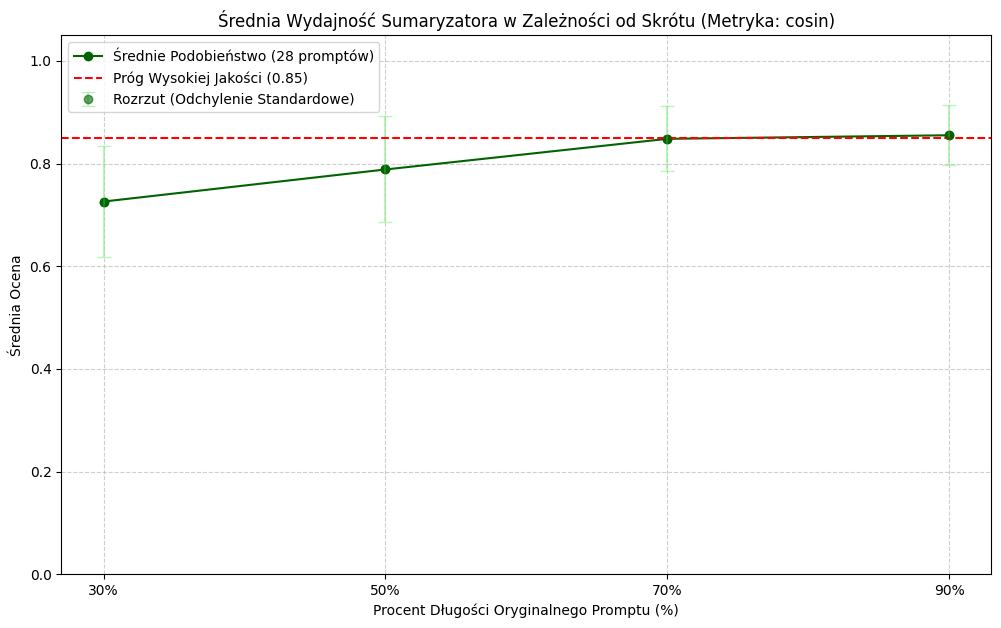

(array([0.3, 0.5, 0.7, 0.9]),
 [np.float32(0.72598517),
  np.float32(0.78845435),
  np.float32(0.8481637),
  np.float32(0.85511583)],
 [np.float32(0.10845759),
  np.float32(0.10324589),
  np.float32(0.062995486),
  np.float32(0.058788758)])

In [10]:
test_multiple_prompts_with_average(df["prompt"], evaluate_function=evaluate)

Rozpoczynanie Testów dla Wielu Promptów (Metryka: api)
1856
614
1856
986
1856
1379
1856
1379
4786
1618
Could not retrieve content from the API.
Błąd dla promptu przy 30%: can only concatenate str (not "NoneType") to str. Pomijanie.
4786
2786
4786
3582
4786
3582
2695
899
2695
1485
2695
1987
2695
2202
2984
934
Could not retrieve content from the API.
Błąd dla promptu przy 30%: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'. Pomijanie.
2984
1558
2984
2256
2984
2362
2428
854
2428
1454
2428
1788
2428
1788
4245
1376
4245
2302
Could not retrieve content from the API.
Błąd dla promptu przy 50%: can only concatenate str (not "NoneType") to str. Pomijanie.
4245
3234
4245
3422
3609
1137
3609
1888
Could not retrieve content from the API.
Błąd dla promptu przy 50%: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'. Pomijanie.
3609
2451
Error parsing response structure: 'parts'
Błąd dla promptu przy 70%: can only concatenate 

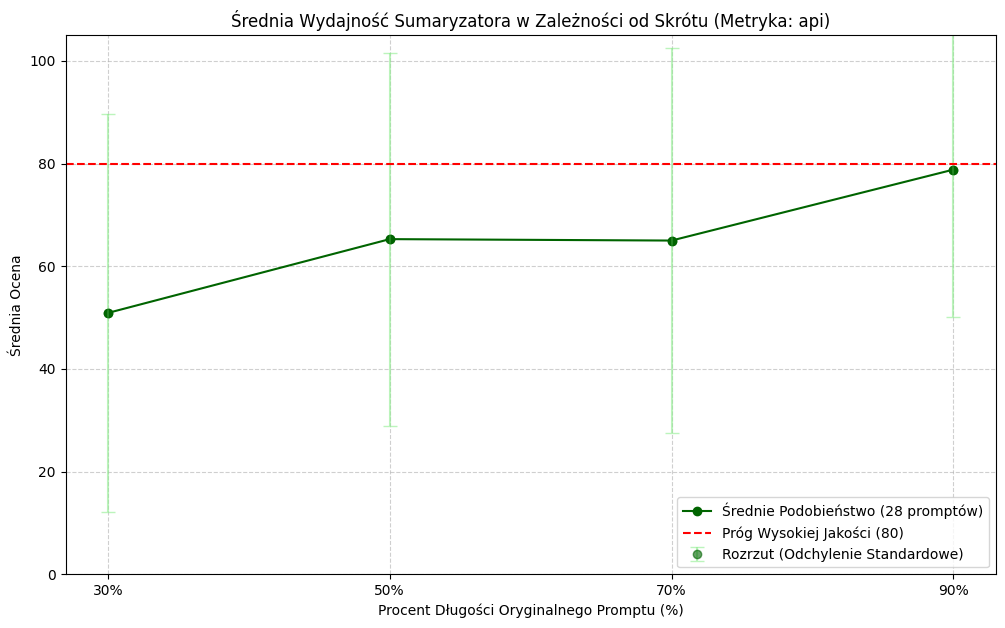

(array([0.3, 0.5, 0.7, 0.9]),
 [np.float64(50.9),
  np.float64(65.27777777777777),
  np.float64(65.0),
  np.float64(78.81818181818181)],
 [np.float64(38.78646671198602),
  np.float64(36.34220924544223),
  np.float64(37.47726583604325),
  np.float64(28.777573913215452)])

In [11]:
test_multiple_prompts_with_average(df["prompt"], evaluate_function=evaluate, metric_name="api")